In [1]:
# %%

import site
import sys

site.addsitedir('../')  # Always appends to end

from kan import *
import numpy as np
import torch
import matplotlib.pyplot as plt
import pdb

from copy import deepcopy


In [3]:
# %%
import math
from torch.utils.data import Dataset

# f = lambda x: (x[:,[0]]**2 + x[:,[2]] + 3*torch.sin(x[:,[1]]))/(x[:,[0]] + 2*x[:,[1]] - x[:,[2]])
# sin(x) * cos(y) + exp(z/2) - x^2 * y
f = lambda x: torch.sin(x[:, [0]]) * torch.cos(x[:, [1]]) + torch.exp(x[:, [2]]/2) - x[:, [0]]**2 * x[:, [1]]

test_num = int((10/0.1)*0.5)
test_num_sub = int((10/0.1)*0.5/8)
seednum = 1

datasetall = create_dataset(f, n_var=3, test_num=test_num, seed=seednum, step_size=0.1, ranges=[[-5, 5], [-5, 5], [-5, 5]])
datasetoct0 = create_dataset(f, n_var=3, test_num=test_num_sub, seed=seednum, step_size=0.1, ranges=[[-5, 0], [-5, 0], [-5, 0]])


TypeError: create_dataset() got an unexpected keyword argument 'step_size'

 ## build KAN architecture

 Training KAN

In [16]:
# %%
# setting bias_trainable=False, sp_trainable=False, sb_trainable=False is important.
# otherwise KAN will have random scaling and shift for samples in previous stages

model = KAN(width=[3,5,1], grid=5, k=3, sp_trainable=False, sb_trainable=False, noise_scale=0.1, device="cpu")
# make a 3D tensor with 5 points in each dimension
x = torch.linspace(-5, 5, steps=11).repeat(3, 1).T

model.update_grid_from_samples(x)
# model = KAN(width=[3,5,1], grid=5, k=3, noise_scale=0.1, device="cpu")
# model.train(datasetoct0, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=0.02);
model.train(datasetoct0, opt="LBFGS", steps=80);

train loss: 2.97e-05 | test loss: 3.50e+01 | reg: 3.60e+01 : 100%|██| 80/80 [00:11<00:00,  7.08it/s]


In [4]:
f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()

In [5]:
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()

In [6]:
# compute R^2 between prediction and true value
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

R^2: 0.9999914228965281
R^2 of total dataset: 0.20941400527954102


continue pruning until R^2 is close to 0.95

R^2 of datasetoct0: 0.9999914228965281
R^2 of datasetoct0: 0.9999914228965281
R^2 of datasetoct0: 0.9999914228965281
R^2 of datasetoct0: 0.9999914228965281
R^2 of datasetoct0: 0.9999914228965281
R^2 of datasetoct0: 0.9387973248958588


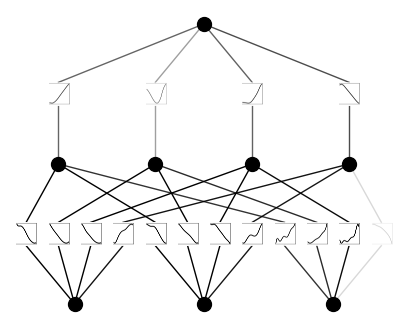

In [7]:
for x in range (1,100):
    threshold_value = 0.01 * x
    model = model.prune(threshold=threshold_value)
    model(datasetoct0['train_input'].to("cpu"))
    f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
    f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
    r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
    print(f"R^2 of datasetoct0: {r2}")
    if r2 < 0.96:
        break

model.plot()

In [8]:
datasetoct1 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=seednum, ranges=[[-5, 0], [-5, 0], [0, 5]])

### freeze/slow down/regularize/stop early network and determine nodes that is the opposite of pruning

In [9]:
# model.train(datasetoct1, opt = 'Adam', steps=5000, update_grid=False, device="cuda", lr=lr_half);

In [10]:
model.train(datasetoct1, opt="LBFGS", steps=int(80/2));
f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct0: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 2.04e-01 | test loss: 2.02e-01 | reg: 2.24e+01 : 100%|██| 40/40 [01:12<00:00,  1.82s/it]

R^2: 0.9999669947537768
R^2 of datasetoct0: 0.9853335656225681
R^2 of total dataset: 0.37371963262557983


Also total dataset has bad r^2. Lack of data?   
Less catastrophic forgetting PROVIDED that the network is well pruned. Occam's Razor?

R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.9999669947537768
R^2 of datasetoct1: 0.8431994915008545


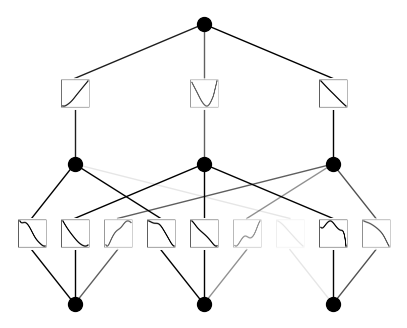

In [11]:
for x in range (1,100):
    threshold_value = 0.01 * x
    model = model.prune(threshold=threshold_value)
    model(datasetoct1['train_input'].to("cpu"))
    f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
    f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
    r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
    print(f"R^2 of datasetoct1: {r2}")
    if r2 < 0.96:
        break

model.plot()

In [13]:
datasetoct2 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [0, 5], [-5, 0]])
model.train(datasetoct2, opt="LBFGS", steps=int(80/3));
# model = model_bk
f_pred = model(datasetoct2['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct2['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetoct1['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct1['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct1: {r2}")

f_pred = model(datasetoct0['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct0['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of datasetoct0: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

train loss: 5.57e-01 | test loss: 5.41e-01 | reg: 3.12e+01 : 100%|██| 26/26 [00:34<00:00,  1.34s/it]

R^2: 0.9996949064661749
R^2 of datasetoct1: -0.6903258562088013
R^2 of datasetoct0: -1.0515315532684326
R^2 of total dataset: 0.03302896022796631


A single iteration of LBFGS causes immediate catastrophic forgetting. Also, repeated dataset creation greatly varies r^2. Dataset quality is the problem.

In [ ]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct2['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct3 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[-5, 0], [0, 5], [0, 5]])
model.train(datasetoct3, opt="LBFGS", steps=int(80/4));
f_pred = model(datasetoct3['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct3['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

In [ ]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct3['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct4 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [-5, 0], [-5, 0]])
model.train(datasetoct4, opt="LBFGS", steps=int(80/5));
f_pred = model(datasetoct4['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct4['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

In [ ]:
model = model.prune(threshold=pruning_threshold)
model(datasetoct4['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct5 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [-5, 0], [0, 5]])
model.train(datasetoct5, opt="LBFGS", steps=int(80/6));
f_pred = model(datasetoct5['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct5['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct5['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct6 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [0, 5], [-5, 0]])
model.train(datasetoct6, opt="LBFGS", steps=int(80/7));
f_pred = model(datasetoct6['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct6['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct6['train_input'].to("cpu"))
model.plot()

In [ ]:
datasetoct7 = create_dataset(f, n_var=3, train_num=trainpoints_subtask, test_num=testpoints_subtask, seed=0, ranges=[[0, 5], [0, 5], [0, 5]])
model.train(datasetoct7, opt="LBFGS", steps=int(80/8));
f_pred = model(datasetoct7['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetoct7['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2: {r2}")

f_pred = model(datasetall['test_input'].to('cpu')).to('cpu').detach().numpy()
f_true = datasetall['test_label'].to('cpu').detach().numpy()
r2 = 1 - np.sum((f_pred - f_true)**2)/np.sum(f_true**2)
print(f"R^2 of total dataset: {r2}")

model = model.prune(threshold=pruning_threshold)
model(datasetoct7['train_input'].to("cpu"))
model.plot()